### Using GloVe embedding as a pretrained model for sarcasm detection

In [25]:
import json

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import re 
from bs4 import BeautifulSoup as BSoup
import string

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud
import numpy as np

#### Loading the json file

- The lines = True , the pandas data frame reads each line as a separate entry in the resulting dataframe which is useful when dealing with large datasets

In [26]:

sarcasm_df = pd.read_json("/media/danlof/dan files/data_science_codes/project_3.2/Sarcasm_v2.json",lines=True) 
sarcasm_df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


### Exploratory Data Analysis

In [27]:
# Do we need the article_link? no

sarcasm_df=sarcasm_df.drop('article_link',axis=1)

In [28]:
# get an overview of the data we are dealing with 
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


- we could say that there are no missing values from the dataset of 28619 entries of news headlines

In [29]:
# produces rows and columns 
sarcasm_df.shape 


(28619, 2)

In [30]:
sarcasm_df.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

In [31]:
# check for duplicates
sarcasm_df.duplicated().sum()

116

In [32]:
# drop the duplicates 
sarcasm_df.drop_duplicates(subset=['headline'],inplace=True)
sarcasm_df.duplicated().sum()
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28503 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28503 non-null  int64 
 1   headline      28503 non-null  object
dtypes: int64(1), object(1)
memory usage: 668.0+ KB


##### Visulization 

- We are going to start visualizing headlines that are sarcastic and non sarcastic ones 

Text(0.5, 1.0, 'A count plot for sacratic and non sarcastic headlines')

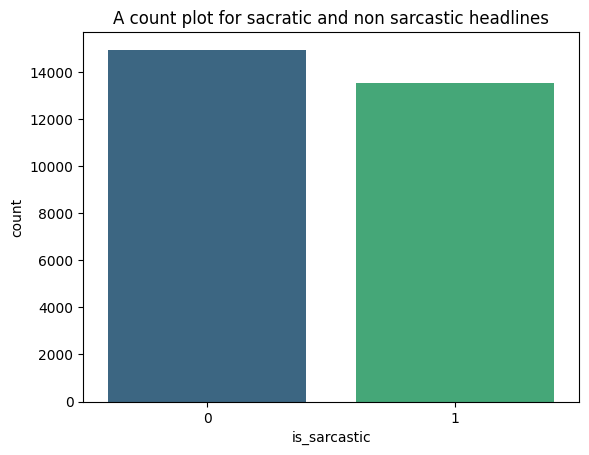

In [33]:
sns.countplot(sarcasm_df,x='is_sarcastic',hue='is_sarcastic',palette='viridis',legend=False)
plt.title('A count plot for sacratic and non sarcastic headlines')

- The countplot show that the sarcastic and non sarcastic headlines have almost the same number of values with a differnce of 1000 items 

#### Clean the headlines 


In [34]:
#check if html tags exist 

def check_for_html(sarcasm_df):
    for key,value in sarcasm_df.items():
        if isinstance(value,str):
            soup = BSoup(value,'htmlparser')
            if soup.find():
                print(f"html tag found in {key}")

        elif isinstance(value,(list,dict)):
            check_for_html(value)

check_for_html(sarcasm_df)



- We got no html tags here 

In [35]:
# let use prepare the stop words

import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

table = str.maketrans('', '', string.punctuation)

[nltk_data] Downloading package stopwords to /home/danlof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:

headlines = []
labels = []
# since we are using a pandas dataframe then it is better to iterate over its rows
for index,row in sarcasm_df.iterrows():
    headline = row['headline'].lower()
    headline = headline.replace(","," , ")
    headline = headline.replace("."," . ")
    headline = headline.replace("/"," / ")
    #headline = re.sub(r'[^a-zA-Z\s]',headline) # removal of non alphabetic symbols
    words = headline.split()
    filtered_headline = ""
    for word in words:
        word = word.translate(table)
        if word not in stop_words:
            filtered_headline = filtered_headline + word + " "
    headlines.append(filtered_headline)
    labels.append(row['is_sarcastic'])
   

    


#### check the length of sentences 

In [37]:
headlines

['thirtysomething scientists unveil doomsday clock hair loss ',
 'dem rep  totally nails congress falling short gender  racial equality ',
 'eat veggies 9 deliciously different recipes ',
 'inclement weather prevents liar getting work ',
 'mother comes pretty close using word streaming correctly ',
 'white inheritance ',
 '5 ways file taxes less stress ',
 'richard bransons globalwarming donation nearly much cost failed balloon trips ',
 'shadow government getting large meet marriott conference room b ',
 'lots parents know scenario ',
 'lesbian considered father indiana amazing one ',
 'amanda peet told daughter sex special hug ',
 'know regarding current treatments ebola ',
 'chris christie suggests hillary clinton blame boko harams kidnapping hundreds schoolgirls ',
 'ford develops new suv runs purely gasoline ',
 'uber ceo travis kalanick stepping trump economic advisory council ',
 'area boy enters jumpingandtouchingtopsofdoorways phase ',
 'area man traveling gurney ',
 'leave pe

(20000.0, 30000.0, 0.0, 200.0)

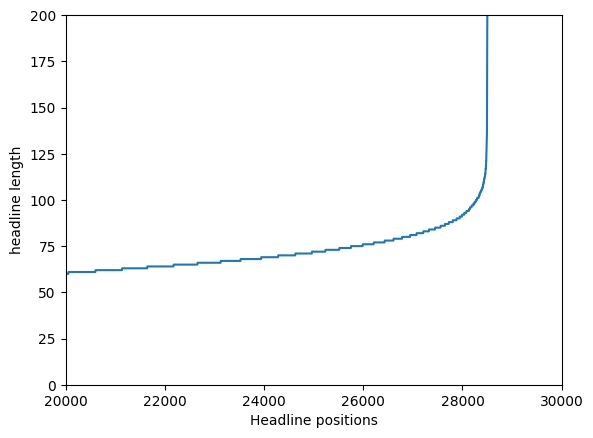

In [38]:
xh =[]
yh = []

current_item = 1
for item in headlines:
    xh.append(current_item)
    current_item = current_item+1
    yh.append(len(item))
newyh = sorted(yh)

import matplotlib.pyplot as plot
plt.plot(xh,newyh)
plt.ylabel("headline length")
plt.xlabel("Headline positions")
# we could zoom alittle
plt.axis([20000,30000,0,200])


- from the above we can conclude that on average most of the headlines have a lengh of about 60 words

### Preprocessing

In [39]:
# initializing different parameters to be using later during training
vocab_size = 6000
embedding_dim = 9
max_length = 75
trunc_type = 'post'
padding_type = 'post'
oov_tok = ""
training_size = 23000 # about 80% of the original dataframe 

In [40]:
# grouping traing and test sets into their respective categories and sizes
training_headers = headlines[0:training_size]
testing_headers = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [41]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(training_headers)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_headers)
training_padded = pad_sequences(training_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type )

testing_sequences = tokenizer.texts_to_sequences(testing_headers)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [42]:
wc = tokenizer.word_counts
print(wc)

OrderedDict([('thirtysomething', 1), ('scientists', 92), ('unveil', 9), ('doomsday', 5), ('clock', 17), ('hair', 49), ('loss', 33), ('dem', 4), ('rep', 22), ('totally', 48), ('nails', 12), ('congress', 113), ('falling', 19), ('short', 34), ('gender', 18), ('racial', 19), ('equality', 15), ('eat', 34), ('veggies', 2), ('9', 106), ('deliciously', 1), ('different', 50), ('recipes', 28), ('inclement', 2), ('weather', 22), ('prevents', 4), ('liar', 7), ('getting', 177), ('work', 161), ('mother', 73), ('comes', 66), ('pretty', 92), ('close', 31), ('using', 59), ('word', 47), ('streaming', 6), ('correctly', 4), ('white', 296), ('inheritance', 2), ('5', 232), ('ways', 109), ('file', 9), ('taxes', 15), ('less', 59), ('stress', 23), ('richard', 23), ('bransons', 1), ('globalwarming', 2), ('donation', 9), ('nearly', 28), ('much', 114), ('cost', 24), ('failed', 27), ('balloon', 11), ('trips', 7), ('shadow', 13), ('government', 86), ('large', 21), ('meet', 66), ('marriott', 1), ('conference', 20), 

#### Checking for word frequencies

In [43]:
# This shows the frequency of the words in the dataset 
import matplotlib.pyplot as plt 
from collections import OrderedDict

newlist = (OrderedDict(sorted(wc.items(),key=lambda t:t[1],reverse=True)))
print(word_index)
print(newlist)

{'': 1, 'new': 2, 'man': 3, 'trump': 4, 'report': 5, 'one': 6, 'u': 7, 'woman': 8, 'area': 9, 'says': 10, 'like': 11, 'donald': 12, 'day': 13, 'first': 14, 'time': 15, 'get': 16, 'people': 17, 'trumps': 18, 'house': 19, 'life': 20, 'white': 21, 'obama': 22, 'make': 23, 'still': 24, 'back': 25, 'women': 26, 'could': 27, 'world': 28, 'years': 29, 'clinton': 30, 'americans': 31, 'way': 32, 'family': 33, '5': 34, 'black': 35, 'study': 36, 'would': 37, 'cant': 38, 'gop': 39, 'know': 40, 'really': 41, 'bill': 42, 'best': 43, 'finds': 44, 'american': 45, 'watch': 46, 'show': 47, 'police': 48, 'good': 49, 'school': 50, 'say': 51, 'going': 52, 'home': 53, 'president': 54, 'things': 55, 'video': 56, 'death': 57, 'nation': 58, 'last': 59, 'getting': 60, 'love': 61, '3': 62, 'big': 63, 'health': 64, 'parents': 65, 'year': 66, 'every': 67, '10': 68, 'mom': 69, 'state': 70, 'campaign': 71, 'need': 72, 'gets': 73, 'party': 74, 'work': 75, 'kids': 76, 'john': 77, 'may': 78, 'right': 79, 'dead': 80, 'l

[1354, 1128, 1082, 488, 445, 408, 406, 393, 383, 375, 375, 359, 351, 348, 347, 331, 317, 312, 308, 296, 295, 290, 281, 279, 259, 252, 252, 249, 243, 234, 234, 234, 232, 219, 216, 214, 208, 205, 204, 203, 202, 200, 200, 195, 195, 194, 192, 192, 191, 191, 191, 191, 188, 186, 185, 185, 183, 178, 177, 177, 175, 175, 175, 174, 173, 173, 172, 171, 170, 168, 168, 167, 165, 161, 160, 159, 158, 158, 157, 157, 156, 155, 153, 153, 151, 151, 151, 150, 150, 149, 148, 147, 147, 147, 147, 146, 144, 143, 143, 143, 143, 141, 141, 140, 137, 136, 136, 135, 135, 135, 134, 134, 134, 131, 131, 131, 130, 129, 128, 127, 127, 126, 126, 125, 125, 125, 125, 125, 124, 123, 123, 122, 122, 122, 120, 120, 120, 118, 117, 116, 115, 115, 115, 115, 114, 113, 113, 113, 112, 112, 112, 112, 112, 111, 110, 110, 110, 109, 109, 109, 109, 109, 109, 108, 107, 106, 106, 106, 106, 106, 106, 106, 104, 103, 103, 103, 102, 102, 102, 101, 101, 101, 100, 100, 100, 100, 99, 99, 99, 99, 99, 98, 98, 98, 97, 97, 97, 97, 97, 96, 96, 96, 95

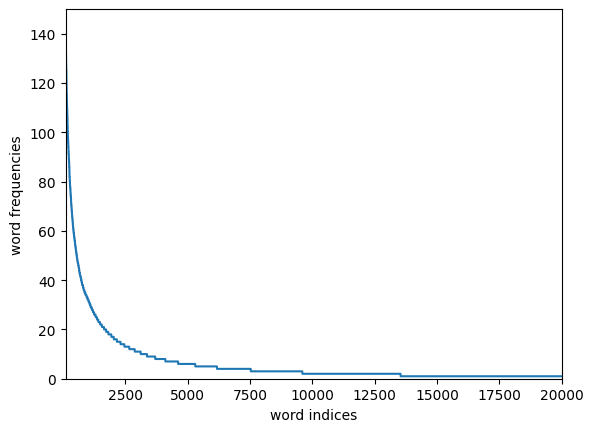

In [44]:
xh=[] # word indices 
yh=[] # word frequencies
curr_x = 1
for item in newlist:
  xh.append(curr_x)
  curr_x=curr_x+1
  yh.append(newlist[item])

print(yh)
plt.plot(xh,yh)
plt.axis([100,20000,0,150])
plt.xlabel("word indices")
plt.ylabel("word frequencies")
plt.show()


- we can conclude that the first 7,000 words make the largest corpus of the word database

In [45]:
# printing the frequencies at different indices
print(yh[2000])
print(yh[4])

17
445


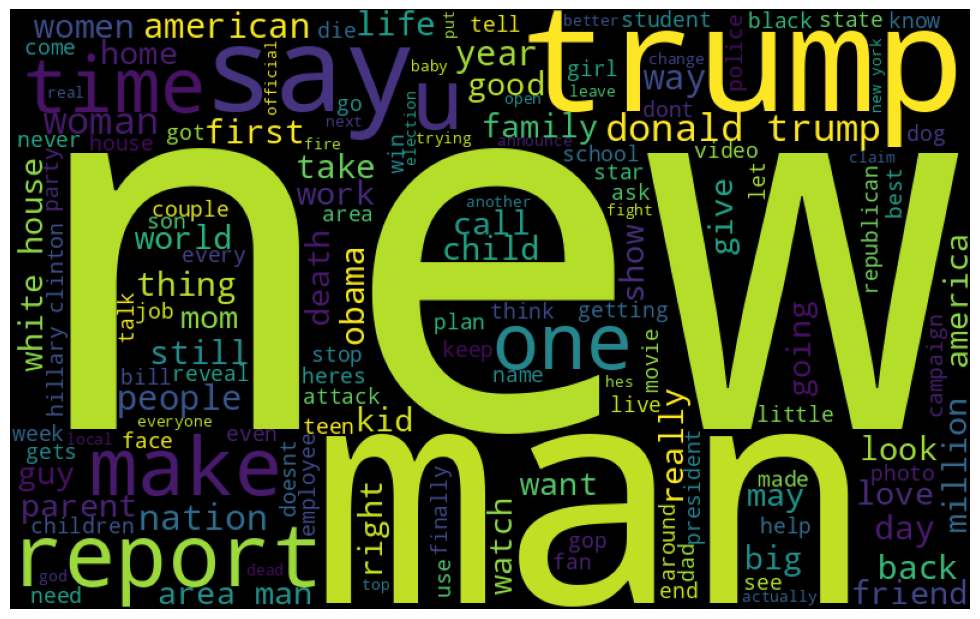

In [46]:
text = ''.join(caption for caption in headlines)
wordcloud = WordCloud(width=800,height=500,background_color='black',min_font_size=10).generate(text)
plt.figure(figsize=(10,6),facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

#### Using GloVe embedding 

In [47]:
embedding_dim = 100# each word will be represented by a word vector of 100 dimensions 


# Load pre-trained GloVe embeddings
embeddings_index = {}
with open('/media/danlof/dan files/gloveEmbedding/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

# Create an embedding matrix
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


### Modelling 

In [68]:
# since we want to use tensorflow for our training then we have to convert our training and test aets into numpy format
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable = False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(20,activation='relu',
                          kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    
    
    tf.keras.layers.Dense(1,activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,amsgrad=False)

model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 75, 100)           2649900   
                                                                 
 global_average_pooling1d_9  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_16 (Dense)            (None, 20)                2020      
                                                                 
 dense_17 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2651941 (10.12 MB)
Trainable params: 2041 (7.97 KB)
Non-trainable params: 2649900 (10.11 MB)
_________________________________________________________________


#### Training the model

In [69]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)
   

Epoch 1/100
719/719 - 2s - loss: 0.7182 - accuracy: 0.5339 - val_loss: 0.7087 - val_accuracy: 0.5746 - 2s/epoch - 2ms/step
Epoch 2/100
719/719 - 1s - loss: 0.7021 - accuracy: 0.5928 - val_loss: 0.6958 - val_accuracy: 0.6040 - 767ms/epoch - 1ms/step
Epoch 3/100
719/719 - 1s - loss: 0.6911 - accuracy: 0.6194 - val_loss: 0.6866 - val_accuracy: 0.6222 - 755ms/epoch - 1ms/step
Epoch 4/100
719/719 - 1s - loss: 0.6830 - accuracy: 0.6303 - val_loss: 0.6796 - val_accuracy: 0.6248 - 850ms/epoch - 1ms/step
Epoch 5/100
719/719 - 1s - loss: 0.6766 - accuracy: 0.6356 - val_loss: 0.6740 - val_accuracy: 0.6286 - 773ms/epoch - 1ms/step
Epoch 6/100
719/719 - 1s - loss: 0.6716 - accuracy: 0.6379 - val_loss: 0.6696 - val_accuracy: 0.6324 - 879ms/epoch - 1ms/step
Epoch 7/100
719/719 - 1s - loss: 0.6674 - accuracy: 0.6397 - val_loss: 0.6659 - val_accuracy: 0.6313 - 794ms/epoch - 1ms/step
Epoch 8/100
719/719 - 1s - loss: 0.6639 - accuracy: 0.6427 - val_loss: 0.6627 - val_accuracy: 0.6389 - 843ms/epoch - 1ms/

##### Model evaluation

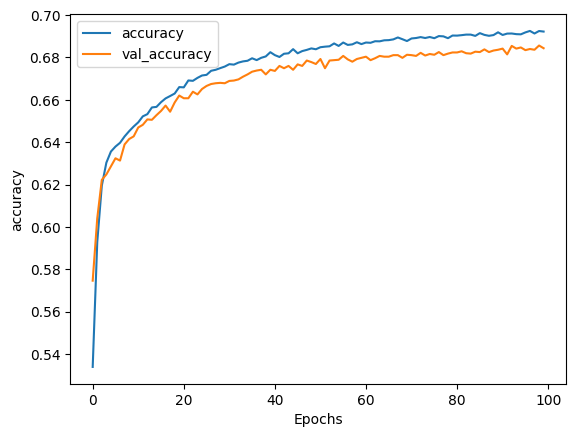

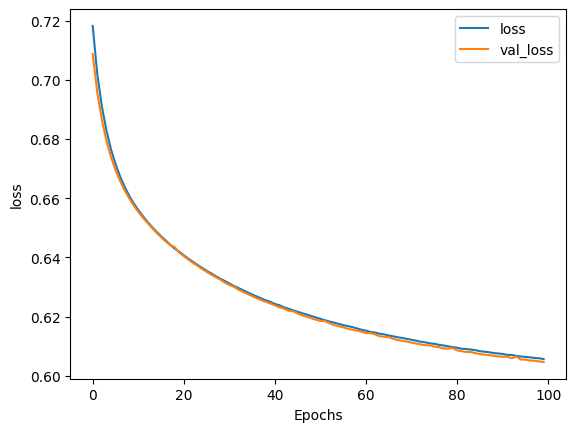

In [70]:
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')